# Plot Detected Physical Drivers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from pathlib import Path
import pickle
import datetime
import time
import glob
import re
import numpy as np

In [5]:
from pcmasking.utils.setup import SetupDiagnostics
from pcmasking.neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from pcmasking.utils.pcmci_aggregation import get_matrix_idx, get_matrix_insets_idx, get_matrix_2d_idx
from pcmasking.neural_networks.model_diagnostics import ModelDiagnostics
from pcmasking.utils.variable import Variable_Lev_Metadata
from pcmasking.utils.constants import SPCAM_Vars
from pcmasking.utils.plotting import plot_matrix_insets

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.transforms as mtransforms

In [7]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [8]:
font_size = 13

In [9]:
plt.rcParams["font.size"] = font_size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.default"] = "regular"

## Setup

In [10]:
PROJECT_ROOT = Path.cwd().parent.resolve()

base_dir = os.path.join(PROJECT_ROOT, "output", "training_91_mask_net_prediction_thresholds_spars0.001") 
train_val = "train"

pre_mask_net_dir = os.path.join(PROJECT_ROOT, "output", "training_74_pre_mask_net_spars0.001")
masking_vector_dir = os.path.join(pre_mask_net_dir, "masking_vectors")


In [11]:
def get_cfg_and_threshold_dir(b_dir, train_or_val):
    if "prediction_thresholds" in b_dir: 
        cfg = os.path.join(b_dir, f"cfg_mask_net_thresholds_{train_or_val}.yml")
        threshold_dir = os.path.join(b_dir, "threshold_performance") 
    else: 
        cfg = os.path.join(b_dir, "cfg_mask_net.yml")
        threshold_dir = os.path.join(bab_dirse_dir, "reference_thresholds")
    return cfg, threshold_dir


In [12]:

def get_outputs_map_file(b_dir, train_or_val):
    if "prediction_thresholds" in Path(b_dir).name:
        shap_dict_dir = Path(b_dir, "plots_offline_evaluation", f"shap_{train_or_val}", "range-all_samples-1000_all")
    else:
        shap_dict_dir = Path(b_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")
    outputs_map_file = Path(b_dir, "outputs_map.txt")

    return outputs_map_file

In [13]:
def get_setup(cfg_file):
    argv  = ["-c", cfg_file]
    return SetupDiagnostics(argv)

## Get Masking Vectors

In [14]:
def parse_txt_to_dict(txt_file):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
    return line_dict

In [15]:
def generate_output_vars(setup):
    output_list = list()
    # Use setup.output_order here instead of setup.spcam_outputs to get the right order of variables
    for spcam_var in setup.spcam_outputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.children_idx_levs:
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                # For CausalSingleNN, there are no networks for variables phq-3.64 and phq-7.59
                if setup.nn_type == "CausalSingleNN" and (var_name == "phq-3.64" or var_name == "phq-7.59"):
                    continue
                output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return output_list

In [16]:
def get_masking_vector(mv_dir, setup):
    output_vars = generate_output_vars(setup)
    
    masking_vector_per_var = dict()
    for var in output_vars: 
        masking_vector = np.load(os.path.join(mv_dir, f"masking_vector_{var}.npy"))
        masking_vector_per_var[var] = masking_vector
    print(f"Loaded masking vector from {mv_dir}")

    return masking_vector_per_var

## Get Thresholds

In [17]:
def load_thresholds_per_var(b_dir, t_dir, train_or_val):
    if "prediction_thresholds" in b_dir: 
        f_name = f"threshold_per_var_{train_or_val}.p"
    else: 
        f_name = "thresholds_per_var.p"
    
    with open(os.path.join(t_dir, f_name), "rb") as in_file:
         t_per_var = pickle.load(in_file)

    return t_per_var
    

In [18]:
def get_thresholded_masking_vector_per_var(thresholds_per_var, mv_per_var, setup):
    td_mv_per_var = dict()
    output_vars = generate_output_vars(setup)
    
    for var in output_vars:
        t = thresholds_per_var[var]
        masking_vector = mv_per_var[var]
        
        t_vector = np.where(masking_vector < t, 
                            np.zeros_like(masking_vector, dtype=int), # value if condition true 
                            np.ones_like(masking_vector, dtype=int)) # value if condition false
        
        td_mv_per_var[var] = t_vector

    return td_mv_per_var

## Get Inputs Matrix

In [19]:
def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)
    

In [20]:
def calculate_input_matrix(setup, inputs_per_var):
    output_vars = {i: var for i, var in enumerate(generate_output_vars(setup))}
    input_vars = generate_input_vars(setup)
    
    num_inputs = len(input_vars)

    input_inverse_idx = list(range(num_inputs-1, -1, -1))
    input_inverse_idx2var = {i: input_vars[num_inputs - 1 - i] for i in range(num_inputs)}
    
    inputs_matrix = np.ma.zeros([len(output_vars), len(input_vars)], dtype=int)
    
    for i, var in output_vars.items():
        if setup.nn_type == "CausalSingleNN" and (str(var) == "phq-3.64" or str(var) == "phq-7.59"):
            # No causal drivers were found for these variables
            continue

        if setup.nn_type == "MaskNet":
            var_inputs_idx = np.flatnonzero(inputs_per_var[var])
        else: 
            var_inputs_idx = inputs_per_var[var]


        for k in range(num_inputs):
            j = input_inverse_idx[k]

            # Check if this input is an input for the current variables
            try:
                inputs_matrix[i, k] = inputs_per_var[var][j]
            except KeyError: 
                # This means the input was not part of the variables network inputs
                pass
            
    return inputs_matrix, input_inverse_idx2var, output_vars


## Plot

In [21]:
def plot_matrix( pc_alpha, matrix, in_vars, in_box_idx, in_ticks, in_ticks_labs, 
                out_vars, out_box_idx, out_ticks, out_ticks_labs, extend, 
                cbar_label, title=None, second_matrix=None, labels=None, only_3d=False, legend_bbox=None,
                **kwargs):
    vars_labs_dict = {
        'tbp': 'T (hPa)',
        'qbp': 'q (hPa)',
        'vbp': 'V (hPa)',
        'tphystnd': r'$\Delta$T$\mathregular{_{phy}}$ (hPa)',
        'phq': '$\Delta$q$\mathregular{_{phy}}$ (hPa)',
    }


    fig, axes = plt.subplots(1, 1, figsize=(12, 5))
       

    if second_matrix is not None:
        # c1 matrix
        # c2 second matrix
        
        alpha_c1 = 0.6
        alpha_c2 = 0.6

        c1 = 'red' 
        c2 = 'royalblue' 


        c1_w_alpha = (c1, alpha_c1) # Adding alpha to the color
        c2_w_alpha = (c2, alpha_c2) # Adding alpha to the color
        
        colors = [c1_w_alpha, c2_w_alpha]

        kwargs.pop("cmap")
        kwargs.pop("interpolation")


        axes.imshow(matrix, cmap=LinearSegmentedColormap.from_list('custom_cmap', ['#FFFFFF', c1]), 
                    alpha=alpha_c1 * (matrix > 0), interpolation="None", **kwargs)
        axes.imshow(second_matrix, cmap=LinearSegmentedColormap.from_list('custom_cmap', ['#FFFFFF', c2]), 
                    alpha=alpha_c2 * (second_matrix > 0), interpolation="None", **kwargs)

        # Create a custom legend
        legend_elements = [mpatches.Patch(facecolor=colors[0], edgecolor='none', label=labels[0]),
                           mpatches.Patch(facecolor=colors[1], edgecolor='none', label=labels[1])]

        if legend_bbox is not None:
            axes.legend(handles=legend_elements, prop={'size': 11}, bbox_to_anchor=legend_bbox, fancybox=True, loc='center right')
        else: 
            axes.legend(handles=legend_elements, prop={'size': 11}, fancybox=True, loc='center right')
        
    else:
        I = axes.imshow(matrix, **kwargs)
        #  (left, bottom, width, height)
        cax = fig.add_axes([axes.get_position().x1 +0.01 , axes.get_position().y0, 
                            0.01, axes.get_position().height])
        cbar = plt.colorbar(I, cax=cax, extend=extend) # Similar to fig.colorbar(im, cax = cax)
        cbar.set_label(cbar_label, fontsize=font_size)
        
    axes.tick_params(bottom=True, left=True, length=4)
    axes.tick_params(axis='x', labelsize=11)
    axes.tick_params(axis='y', labelsize=11)
    
    axes.set_xticks(in_ticks)
    axes.set_xticklabels(in_ticks_labs)
    axes.set_yticks(out_ticks)
    axes.set_yticklabels(out_ticks_labs)

    if only_3d:
        labels = axes.get_yticklabels()
        # offset bottom label 
        offset = mtransforms.ScaledTranslation(0, +0.04, fig.dpi_scale_trans)
        labels[-1].set_transform(labels[-1].get_transform() + offset)
        

    if not only_3d: 
        axes.vlines(in_box_idx, ymin=-.5, ymax=len(matrix), color='k')
        axes.hlines(out_box_idx, xmin=-.5, xmax=len(matrix[0]), color='k')
    else: 
        axes.vlines(in_box_idx[1:], ymin=-.5, ymax=len(matrix), color='k')
        axes.hlines(out_box_idx[:-1], xmin=-.5, xmax=len(matrix[0]), color='k')

    axes.set_xlim(xmax=len(matrix[0]) - .5)
    axes.set_ylim(ymin=len(matrix) - .5)

    trans = axes.get_xaxis_transform()

    if not only_3d:
        # Annotate y-axis (outputs)
        xy_coor = [(-13., .68), (-13., .20)]
        for i, iVar in enumerate(out_vars):
            axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=90, fontsize=font_size)
        axes.annotate('out-2Ds', xy=(-20.1, .005), xycoords=trans, rotation=0, fontsize=font_size)

        # Annotate x-axis (inputs)
        xy_coor = [(12., -.13), (42., -.13), (72., -.13)]
        for i, iVar in enumerate(in_vars):
            axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)
        axes.annotate('in-2Ds', xy=(.6, -.25), xycoords=trans, rotation=90, fontsize=font_size)

    else: 
        # Annotate y-axis (outputs)
        xy_coor = [(-13., .65), (-13., .17)]
        for i, iVar in enumerate(out_vars):
            axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=90, fontsize=font_size)

        # Annotate x-axis (inputs)
        xy_coor = [(10., -.13), (40., -.13), (70., -.13)]
        for i, iVar in enumerate(in_vars):
            axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)

    
    axes.set_title(title, fontsize=font_size)
    return fig, axes

In [22]:
def plot_matrix_shap(input_dict_inv_remap_var, dict_outputs_idxs, input_matrix, 
                     second_matrix=None, labels=None, title=None, f_name="", 
                     diff=False, save=False, savenm=False, cmap=False, legend_bbox=None,
                     extend=False, interpolation='none', only_3d=False, **kwargs):

    if only_3d: 
        input_dict_inv_remap_var = {key: value for key, value in input_dict_inv_remap_var.items() if value.var.name in ['vbp', 'tbp', 'qbp']}
        dict_outputs_idxs = {key: value for key, value in dict_outputs_idxs.items() if value.var.name in ['tphystnd', 'phq']}

        input_matrix = input_matrix[list(dict_outputs_idxs.keys()), :][:, list(input_dict_inv_remap_var.keys())]

        if second_matrix is not None:
            second_matrix = second_matrix[list(dict_outputs_idxs.keys()), :][:, list(input_3d_only.keys())]
    
    # Miscellaneous for plotting
    in_vars, in_box_idx, in_ticks, in_ticks_labs = get_matrix_insets_idx(input_dict_inv_remap_var, inverted=True)
    out_vars, out_box_idx, out_ticks, out_ticks_labs = get_matrix_insets_idx(dict_outputs_idxs)
    # hack, but works
    out_ticks -= 0.5

    if not cmap: cmap='Blues'
    if not extend: extend='max'
    cbar_label=''
            
   
    fig, ax = plot_matrix(None, input_matrix,
                          in_vars, in_box_idx, in_ticks, in_ticks_labs,
                          out_vars, out_box_idx, out_ticks,  out_ticks_labs,
                          extend, cbar_label,
                          cmap=cmap,
                          interpolation=interpolation, 
                          second_matrix=second_matrix, 
                          labels=labels, 
                          title=title,
                          only_3d=only_3d, 
                          legend_bbox=legend_bbox,
                          )
    ax.set_rasterized(True)
    
    if save:
        Path(save).mkdir(parents=True, exist_ok=True)
        fig.savefig(os.path.join(save, f"{f_name}.pdf"), format="pdf", bbox_inches="tight", transparent=True)
        fig.savefig(os.path.join(save, f"{f_name}.svg"), format="svg", bbox_inches="tight", transparent=True)
        fig.savefig(os.path.join(save, f"{f_name}.png") ,dpi=600.,bbox_inches='tight', transparent=True)
        
        print(f"Saved input matrix {save}/{f_name}.pdf/png")
    return fig, ax

## Reference Climate

In [23]:
ref_base_dir = os.path.join(PROJECT_ROOT, "output", "training_91_mask_net_prediction_thresholds_spars0.001") 
train_val = "train"

ref_pre_mask_net_dir = os.path.join(PROJECT_ROOT, "output", "training_74_pre_mask_net_spars0.001")
ref_masking_vector_dir = os.path.join(ref_pre_mask_net_dir, "masking_vectors")

ref_output_dir = os.path.join(ref_base_dir, "plots_offline_evaluation", "physical_drivers")

In [24]:
ref_cfg, ref_threshold_dir = get_cfg_and_threshold_dir(ref_base_dir, train_val)

ref_setup = get_setup(ref_cfg)
ref_mv_per_var = get_masking_vector(ref_masking_vector_dir, ref_setup)

ref_thresholds_per_var = load_thresholds_per_var(ref_base_dir, ref_threshold_dir, train_val)

ref_thresholded_mv_per_var = get_thresholded_masking_vector_per_var(ref_thresholds_per_var, ref_mv_per_var, ref_setup)

Loaded masking vector from /p/scratch/icon-a-ml/kuehbacher1/output/training_74_pre_mask_net_spars0.001/masking_vectors


In [25]:
ref_input_matrix, ref_input_inverse_idx2var, ref_output_vars_idx = calculate_input_matrix(ref_setup, 
                                                                                          ref_thresholded_mv_per_var)

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/physical_drivers/inputs_0k_mask_net.pdf/png


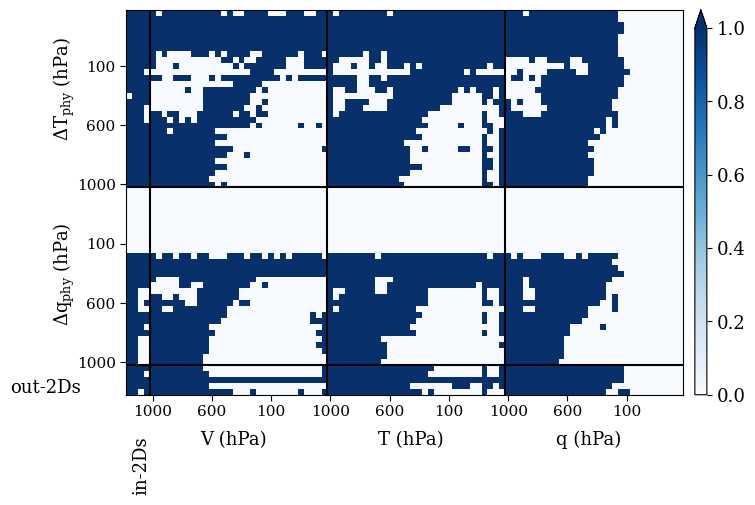

In [26]:
plot_name = "inputs_0k_mask_net"
fig, ax = plot_matrix_shap(ref_input_inverse_idx2var, ref_output_vars_idx, ref_input_matrix,
                           cmap="Blues", f_name=plot_name, save=ref_output_dir)


## +4K Climate

In [27]:
plus4k_base_dir = os.path.join(PROJECT_ROOT, "output", "training_103_mask_net_prediction_thresholds_spars0.001_plus4k") 

plus4k_pre_mask_net_dir = os.path.join(PROJECT_ROOT, "output", "training_101_pre_mask_net_spars0.001_plus4k")
plus4k_masking_vector_dir = os.path.join(plus4k_pre_mask_net_dir, "masking_vectors")

plus4k_output_dir = os.path.join(plus4k_base_dir, "plots_offline_evaluation", "physical_drivers")

In [28]:
plus4k_cfg, plus4k_threshold_dir = get_cfg_and_threshold_dir(plus4k_base_dir, train_val)

plus4k_setup = get_setup(plus4k_cfg)
plus4k_mv_per_var = get_masking_vector(plus4k_masking_vector_dir, plus4k_setup)

plus4k_thresholds_per_var = load_thresholds_per_var(plus4k_base_dir, plus4k_threshold_dir, train_val)

plus4k_thresholded_mv_per_var = get_thresholded_masking_vector_per_var(plus4k_thresholds_per_var, plus4k_mv_per_var, plus4k_setup)

Loaded masking vector from /p/scratch/icon-a-ml/kuehbacher1/output/training_101_pre_mask_net_spars0.001_plus4k/masking_vectors


In [29]:
plus4k_input_matrix, plus4k_input_inverse_idx2var, plus4k_output_vars_idx = calculate_input_matrix(plus4k_setup, 
                                                                                                   plus4k_thresholded_mv_per_var)

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_103_mask_net_prediction_thresholds_spars0.001_plus4k/plots_offline_evaluation/physical_drivers/inputs_plus4k_mask_net.pdf/png


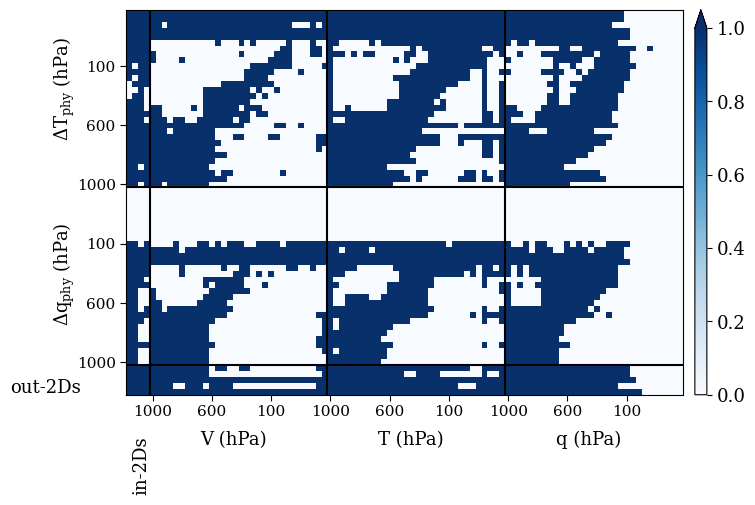

In [30]:
plot_name = "inputs_plus4k_mask_net"

fig, ax = plot_matrix_shap(plus4k_input_inverse_idx2var, plus4k_output_vars_idx, plus4k_input_matrix,
                           cmap="Blues", f_name=plot_name, save=plus4k_output_dir)



## -4K climate

In [31]:
minus4k_base_dir = os.path.join(PROJECT_ROOT, "output", "training_104_mask_net_prediction_thresholds_spars0.001_minus4k") 

minus4k_pre_mask_net_dir = os.path.join(PROJECT_ROOT, "output", "training_102_pre_mask_net_spars0.001_minus4k")
minus4k_masking_vector_dir = os.path.join(minus4k_pre_mask_net_dir, "masking_vectors")

minus4k_output_dir = os.path.join(minus4k_base_dir, "plots_offline_evaluation", "physical_drivers")

In [32]:
minus4k_cfg, minus4k_threshold_dir = get_cfg_and_threshold_dir(minus4k_base_dir, train_val)

minus4k_setup = get_setup(minus4k_cfg)
minus4k_mv_per_var = get_masking_vector(minus4k_masking_vector_dir, minus4k_setup)

minus4k_thresholds_per_var = load_thresholds_per_var(minus4k_base_dir, minus4k_threshold_dir, train_val)

minus4k_thresholded_mv_per_var = get_thresholded_masking_vector_per_var(minus4k_thresholds_per_var, minus4k_mv_per_var, minus4k_setup)

Loaded masking vector from /p/scratch/icon-a-ml/kuehbacher1/output/training_102_pre_mask_net_spars0.001_minus4k/masking_vectors


In [33]:
minus4k_input_matrix, minus4k_input_inverse_idx2var, minus4k_output_vars_idx = calculate_input_matrix(minus4k_setup, 
                                                                                                      minus4k_thresholded_mv_per_var)

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_104_mask_net_prediction_thresholds_spars0.001_minus4k/plots_offline_evaluation/inputs/inputs_minus4k_mask_net.pdf/png


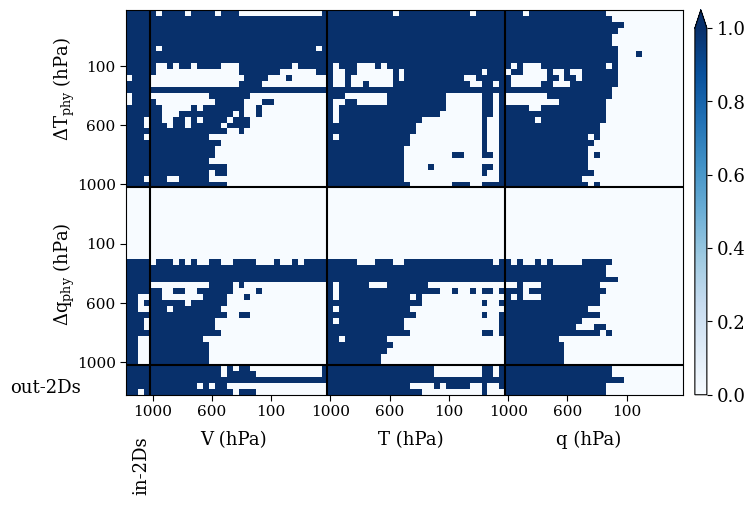

In [34]:
plot_name = "inputs_minus4k_mask_net"

fig, ax = plot_matrix_shap(minus4k_input_inverse_idx2var, minus4k_output_vars_idx, minus4k_input_matrix,
                           cmap="Blues", f_name=plot_name, save=minus4k_output_dir)



## Overlay reference with +4K

In [35]:
output_dir = os.path.join(ref_base_dir, "plots_physical_drivers")
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_physical_drivers


In [36]:
input_3d_only = {key: value for key, value in ref_input_inverse_idx2var.items() if value.var.name in ['vbp', 'tbp', 'qbp']}
output_3d_only = {key: value for key, value in ref_output_vars_idx.items() if value.var.name in ['tphystnd', 'phq']}
    

In [37]:
ref_input_matrix[list(output_3d_only.keys()), :][:, list(input_3d_only.keys())].shape

(60, 90)

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_physical_drivers/inputs_ref_plus4k_mask_net_only_3d.pdf/png


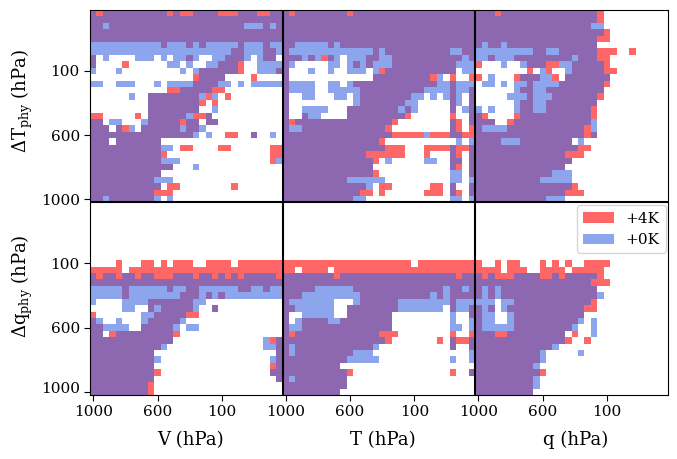

In [38]:
only_3d = True

if only_3d:
    plot_name = "inputs_ref_plus4k_mask_net_only_3d"
else:   
    plot_name = "inputs_ref_plus4k_mask_net"

fig, ax = plot_matrix_shap(ref_input_inverse_idx2var, ref_output_vars_idx, plus4k_input_matrix,
                           second_matrix=ref_input_matrix, labels={0: "+4K", 1:"+0K"}, only_3d=only_3d,
                           legend_bbox=(1.01, 0.43),
                           f_name=plot_name, save=output_dir)



## Overlay refernce with -4K

In [39]:
output_dir = os.path.join(ref_base_dir, "plots_paper_inputs")

Saved input matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_paper_inputs/inputs_ref_minus4k_mask_net.pdf/png


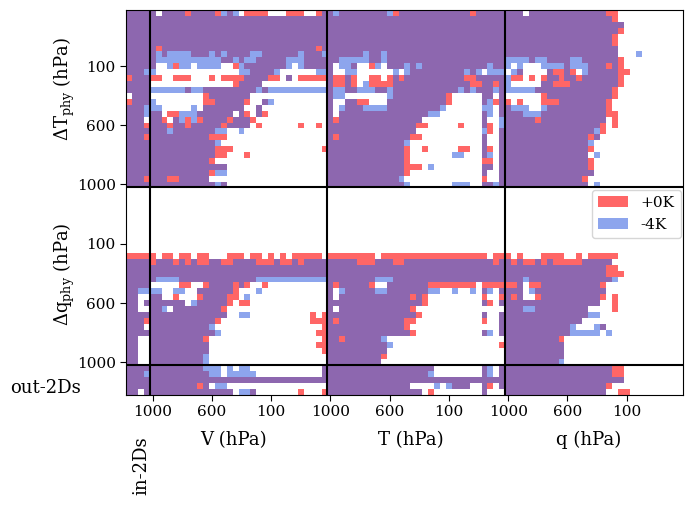

In [40]:
only_3d = False

if only_3d:
    plot_name = "inputs_ref_minus4k_mask_net_only_3d"
else:   
    plot_name = "inputs_ref_minus4k_mask_net"

fig, ax = plot_matrix_shap(ref_input_inverse_idx2var, ref_output_vars_idx, ref_input_matrix,
                           second_matrix=minus4k_input_matrix, labels={0: "+0K", 1: "-4K"}, only_3d=only_3d,
                           legend_bbox=(1.01, 0.47),
                           f_name=plot_name, save=output_dir)
    
